In [1]:
from core.preprocessing import make_small_train, make_small_dev, StatisticalClearSky
import numpy as np
import pandas as pd
df = pd.read_pickle('data/master_dataset.pkl').fillna(0)
df = df.loc['2015-07-15':'2017-07-14']
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

In [2]:
def plot_trends_and_total(df, start=None, stop=None):
    if start is None:
        start = df.index[0]
    if stop is None:
        stop = df.index[-1]
    cols = df.columns
    fig, axes = plt.subplots(nrows=2, figsize=(12,10), sharex=True)
    df.loc[start:stop].plot(y=cols[:-1], legend=False, linewidth=1, ax=axes[0])
    df.loc[start:stop].plot(y=cols[-1], linewidth=1, ax=axes[1])

mixed = make_small_train(df, 'mixed')
plot_trends_and_total(mixed)

sunny = make_small_train(df, 'sunny')
plot_trends_and_total(sunny)

cloudy = make_small_train(df, 'cloudy')
plot_trends_and_total(cloudy)

comb = make_small_train(df, 'combined')
plot_trends_and_total(comb)

dev = make_small_dev(df)
plot_trends_and_total(dev)

from core.problems import ManyToOneRegression

# Problem parameters
window = 5*12 # window size (to be determined from correlation analysis)
future = 3*12  # prediction window into the future

# Optimization parameters
nepochs = 50
batchsize = 1000

problem = ManyToOneRegression(mixed, window=window, future=future)

feat = problem.featurize(100)

%time np.array([mixed.iloc[i:i+window, :-1].values.ravel() for i in xrange(len(mixed) - problem.window - problem.future)]).shape

mixed.shape

i = 75
mixed.iloc[i:i+window, :-1].values.ravel()

In [3]:
scs = StatisticalClearSky(df['S04'])

In [4]:
scs.get_eigenvectors()

<Container object of 3 artists>

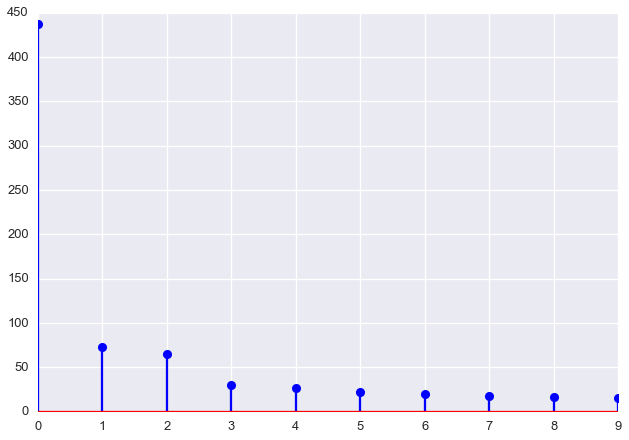

In [5]:
plt.stem(scs.D[:10])

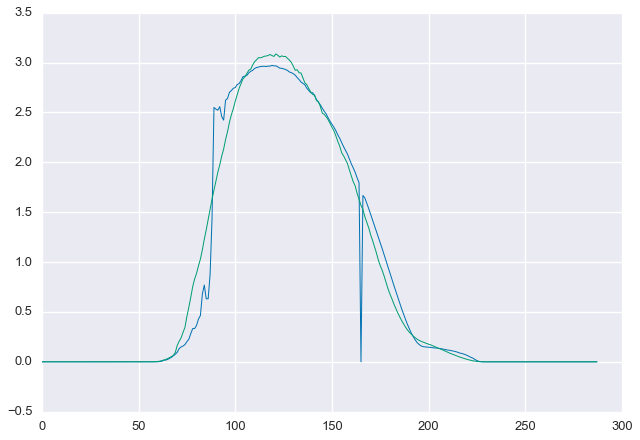

In [6]:
scs.reconstruct_day(day=2, n=3)

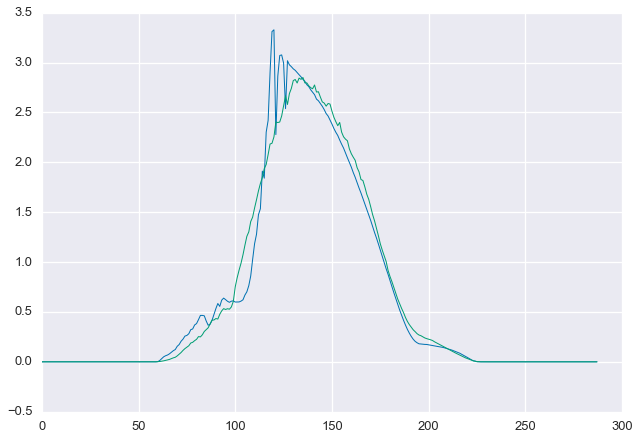

In [7]:
scs.reconstruct_day(day=317, n=3)

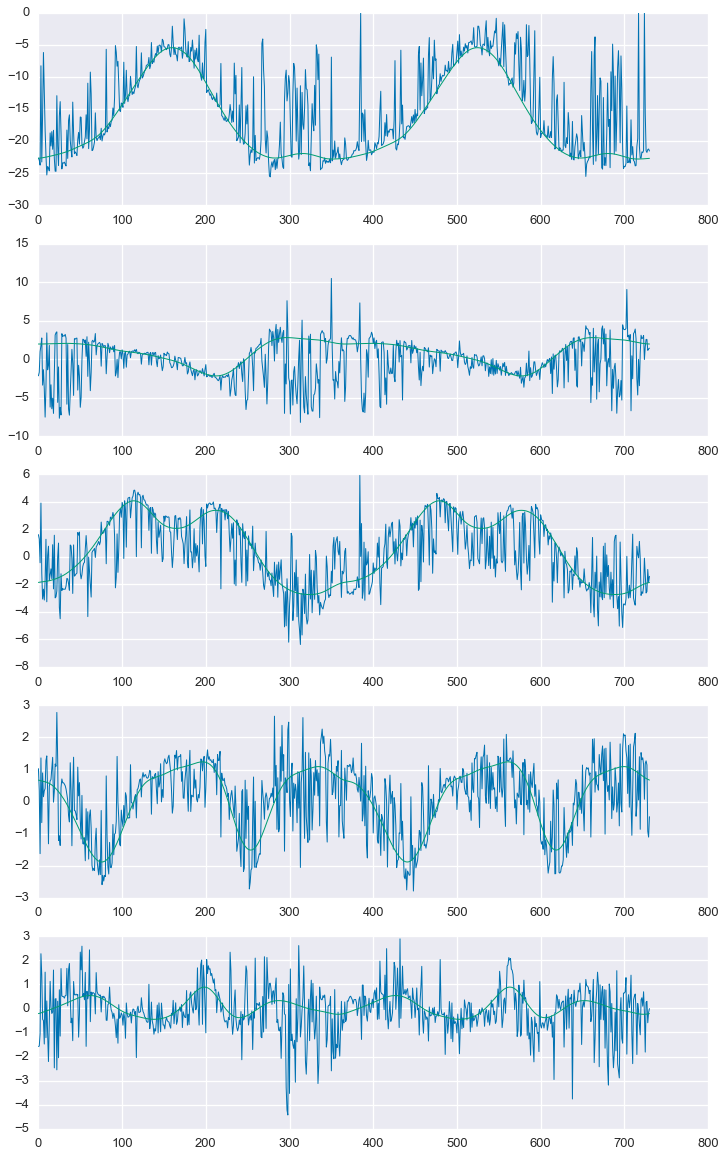

In [8]:
_ = scs.make_clearsky_model(plot=True)

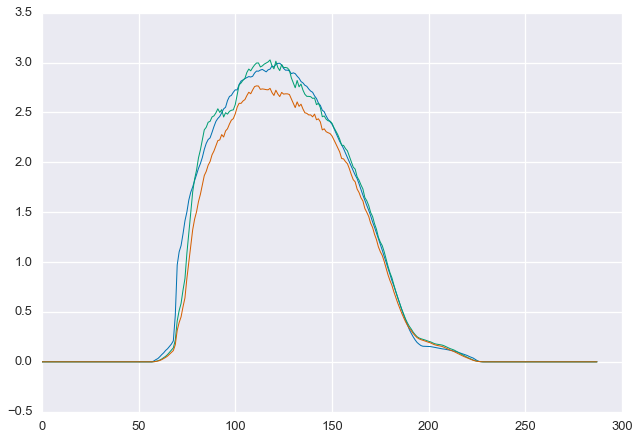

In [9]:
DAY = 337
scs.reconstruct_day(DAY, n=5)
estimates = scs.estimate_clearsky(np.s_[DAY:DAY+1])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i], linewidth=1)

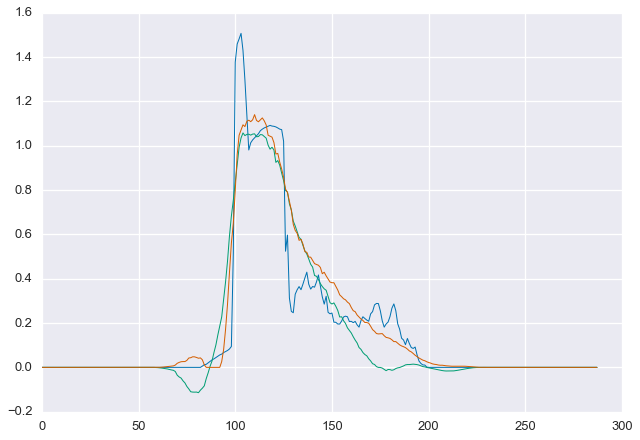

In [10]:
DAY = 151
scs.reconstruct_day(DAY, n=3)
estimates = scs.estimate_clearsky(np.s_[DAY:DAY+1])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i], linewidth=1)

In [11]:
np.sort(np.array(list(set(df.index.date))))[125]

datetime.date(2015, 11, 17)

In [12]:
import datetime
np.where(np.sort(np.array(list(set(df.index.date)))) == datetime.date(2015, 11, 14))

(array([122]),)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


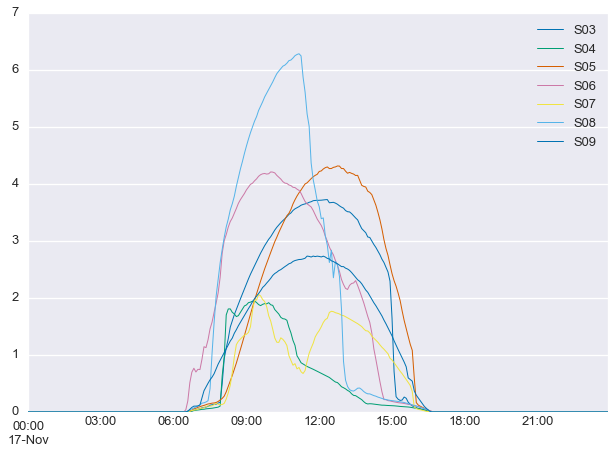

In [13]:
df.loc['2015-11-17':'2015-11-17'].plot(y=df.columns[2:9], linewidth=1)

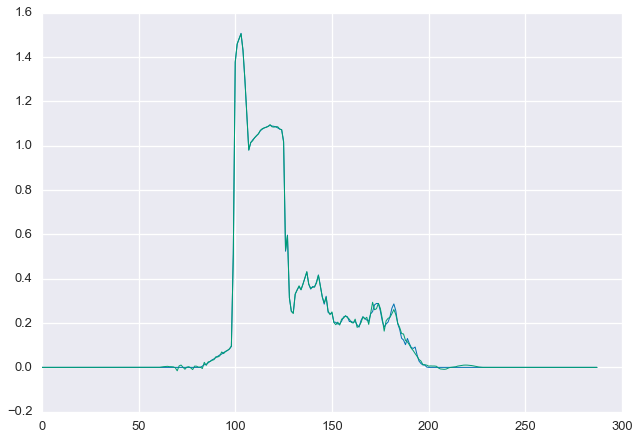

In [14]:
scs.reconstruct_day(day=151)

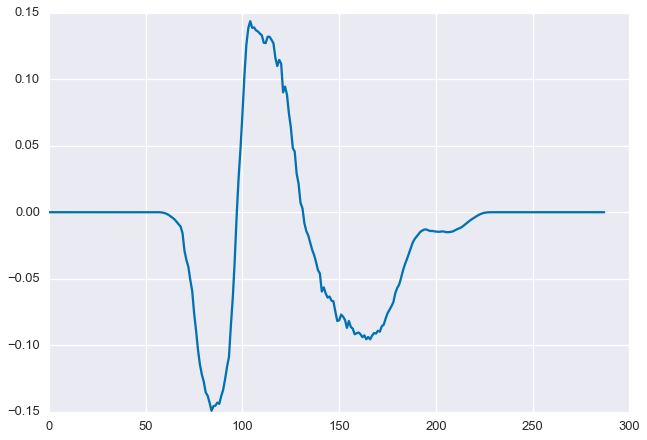

In [15]:
plt.plot(scs.U[:, 2])

In [16]:
scs = StatisticalClearSky(df['S21'])

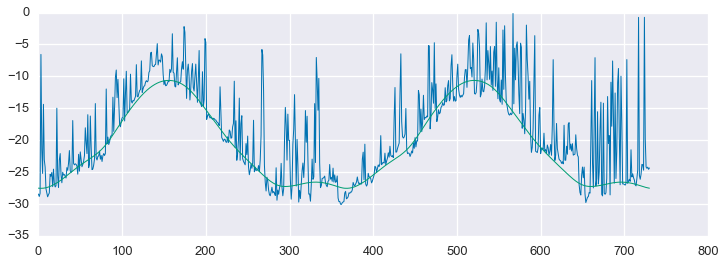

In [17]:
_ = scs.make_clearsky_model(plot=True, n=1)

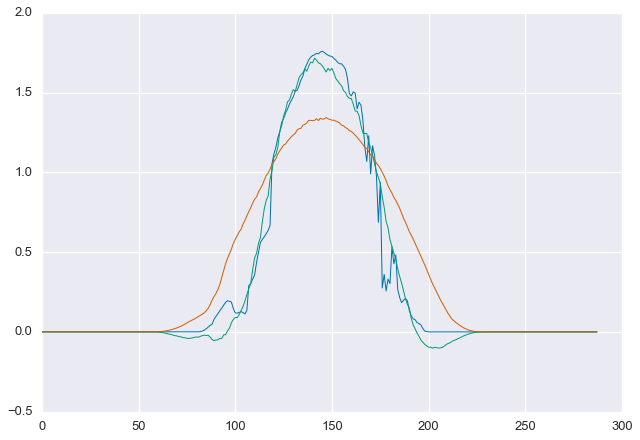

In [18]:
DAY = 151
scs.reconstruct_day(DAY, n=3)
estimates = scs.estimate_clearsky(np.s_[DAY:DAY+1])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i], linewidth=1)

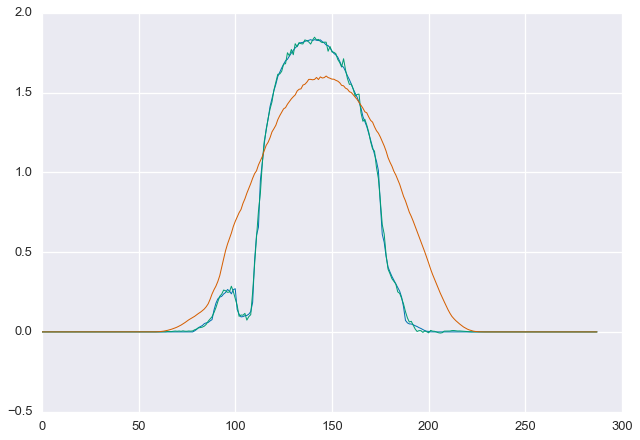

In [19]:
DAY = 125
scs.reconstruct_day(DAY, n=40)
estimates = scs.estimate_clearsky(np.s_[DAY:DAY+1])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i], linewidth=1)

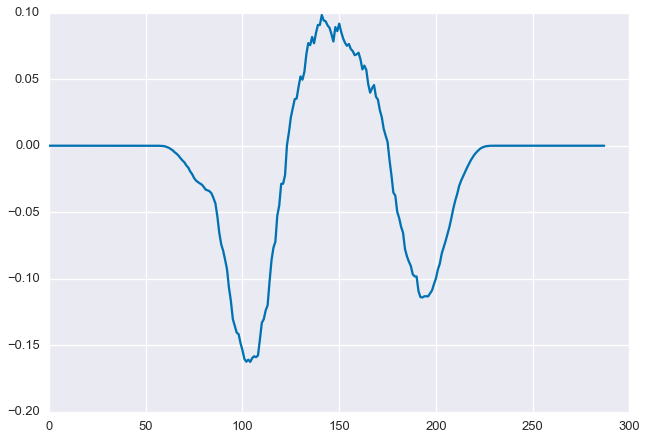

In [20]:
plt.plot(scs.U[:, 1])

<Container object of 3 artists>

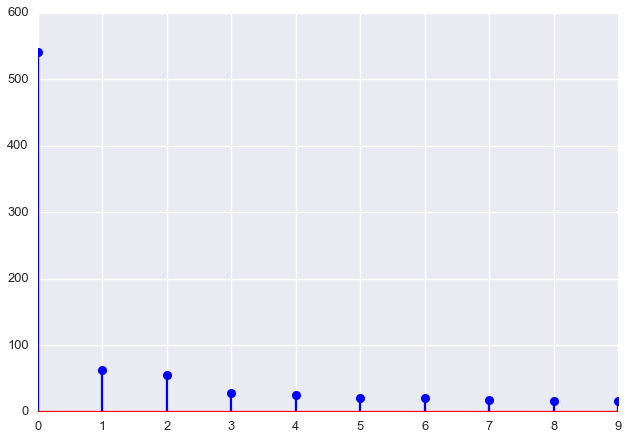

In [21]:
plt.stem(scs.D[:10])

In [22]:
scs.D[1] / scs.D[0]

0.1158469329519452

In [23]:
scs.DP_clearsky.shape

(1, 365)

In [24]:
signals, fits = scs.make_clearsky_model(plot=False, n=10, return_fits=True)

In [25]:
index = np.arange(len(signals[0]))

In [26]:
selector = np.abs(signals[0] - fits[0]) < 1.5

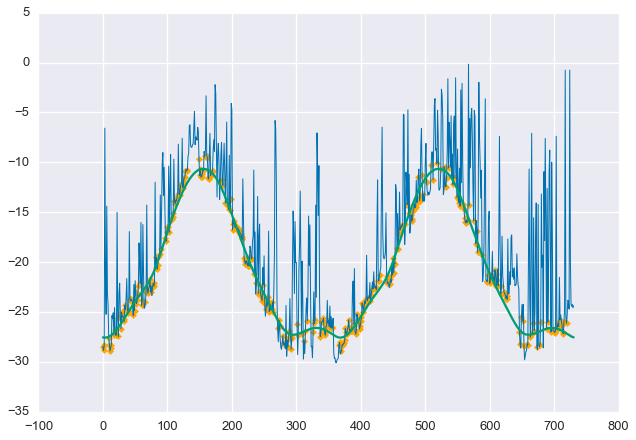

In [27]:
plt.plot(signals[0], linewidth=1)
plt.plot(fits[0])
plt.scatter(index[selector], signals[0][selector], color='orange', marker='D')

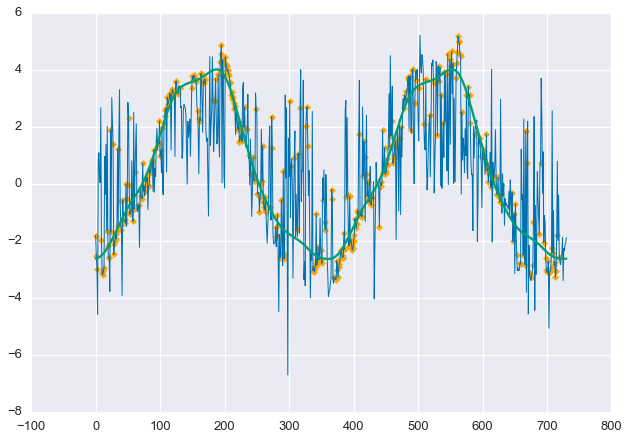

In [39]:
plt.plot(signals[1], linewidth=1)
plt.scatter(index[selector], signals[1][selector], color='orange', marker='D')
plt.plot(fits[1])

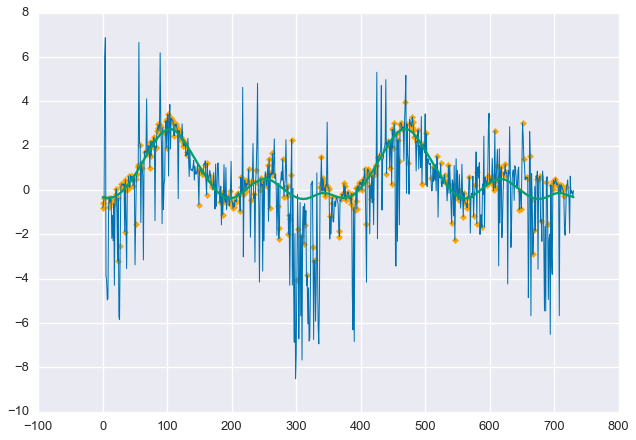

In [29]:
plt.plot(signals[2], linewidth=1)
plt.scatter(index[selector], signals[2][selector], color='orange', marker='D')
plt.plot(fits[2])

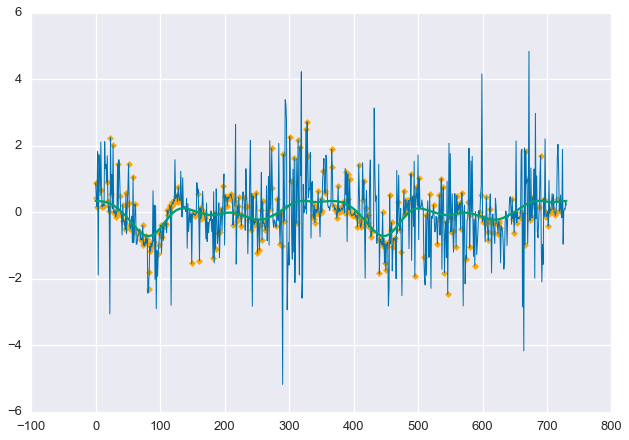

In [30]:
plt.plot(signals[3], linewidth=1)
plt.scatter(index[selector], signals[3][selector], color='orange', marker='D')
plt.plot(fits[3])

In [31]:
import cvxpy as cvx
from core.utilities import masked_smooth_fit_periodic

In [32]:
fit = cvx.Variable(len(signals[1]))
mu = cvx.Parameter(sign='positive', value=10**2)
cost = (cvx.norm2(fit[selector] - signals[1][selector]) + mu * cvx.norm2(fit[2:] - 2 * fit[1:-1] + fit[:-2]))
objective = cvx.Minimize(cost)
constraints = [fit[:len(signals[1]) - 365] == fit[365:]]
problem = cvx.Problem(objective, constraints)

In [33]:
problem.solve('MOSEK')

21.571066431854796

In [34]:
fit_test = masked_smooth_fit_periodic(signals[1], selector, 365, 10**2)

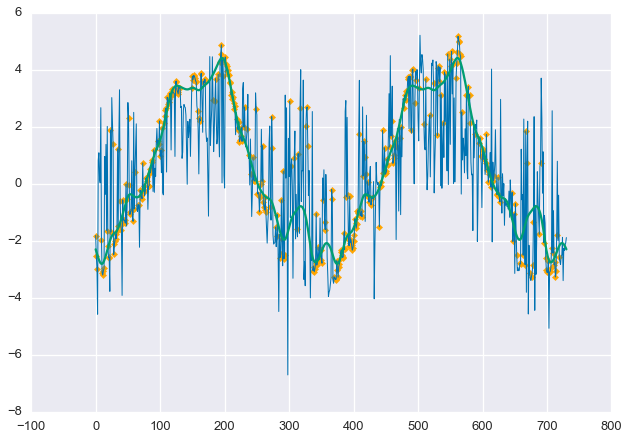

In [35]:
plt.plot(signals[1], linewidth=1)
plt.scatter(index[selector], signals[1][selector], color='orange', marker='D')
plt.plot(fit_test)

In [36]:
selector2 = np.abs(signals[1] - fit_test) < 1

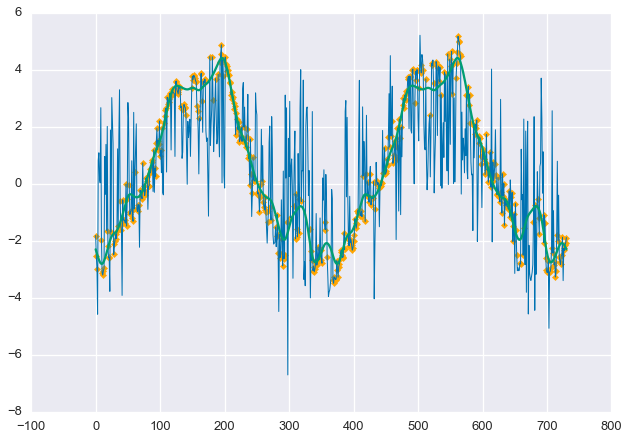

In [37]:
plt.plot(signals[1], linewidth=1)
plt.scatter(index[selector2], signals[1][selector2], color='orange', marker='D')
plt.plot(fit_test)

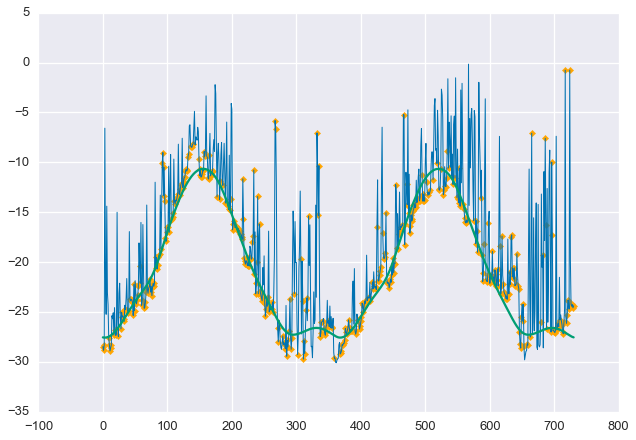

In [38]:
plt.plot(signals[0], linewidth=1)
plt.plot(fits[0])
plt.scatter(index[selector2], signals[0][selector2], color='orange', marker='D')